## 04. 영업사원문제(Traveling Salesman Problem)

- 사용데이터 :

    - Open Street Map 데이터를 API로 참조해서 사용
    - 한국관광공사 관광데이터랩 네비게이션 데이터 활용

- 작성자 : 권도희(epik5064@naver.com)

- 최종수정일 : 2025.12.23

[수정이력]
- 2025.12.22 최초작성
- 2025.12.23 관광루트 탐색방법 작성, 랜덤시드 적용되도록 수정

In [1]:
## 사용 라이브러리 정리
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import geopandas as gpd
from typing import Optional, Dict, Any
import time
import random

## 네트워크데이터 가져오기
import osmnx as ox

## 네트워크 분석용
import networkx as nx

## 클러스터링 등 ML 계산용
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## 시각화
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import contextily as ctx

## GIS 라이브러리
from shapely.geometry import Point

## api 요청용
import requests
from dotenv import load_dotenv

### 1. Traveling Salesman Problem(TSP)

- 네트워크 분석에서 아주 오래된 주제로, 주어진 모든 지점을 한번식 방문하고 다시 출발점으로 돌아오는 최소경로를 찾는 문제

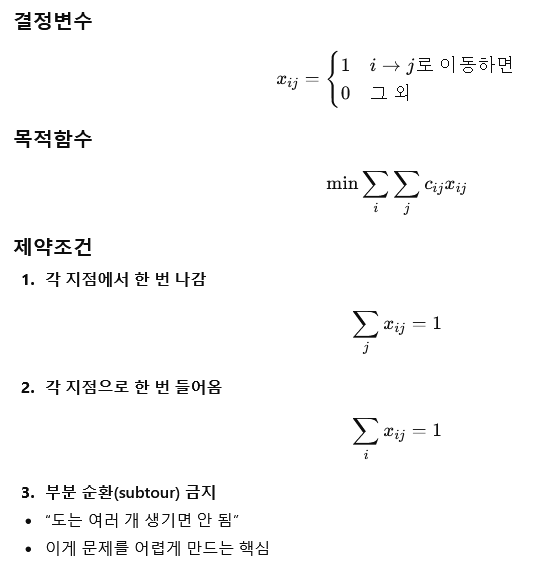

[TSP 해결 알고리즘]

- 1) Heuristic algorithm : nearest neighbor 방법을 사용하여, 현재 위치에서 가장 가까운 미방문 지점으로 이동

- 2) Local Search : 이미 존재하는 경로를 수정하여 개선 (2-opt를 많이 사용)

- 3) Metaheuristics : 여러가지 문제를 한꺼번에 고려하여 확률적으로 탐색

#### 1.1 샘플 데이터 생성

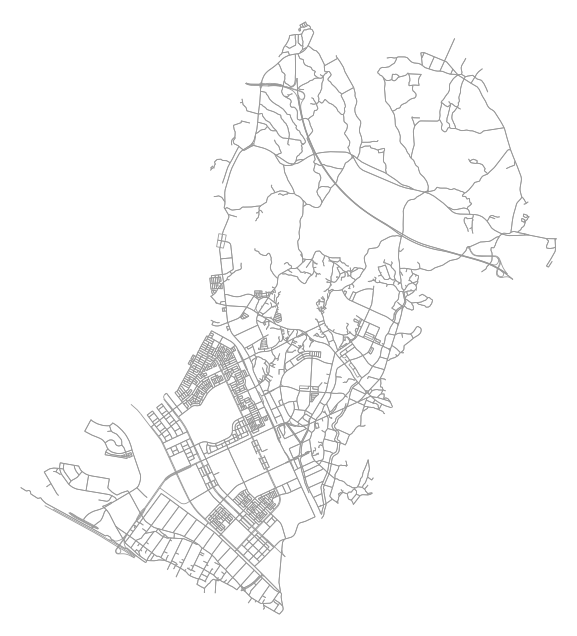

노드 수: 2341
엣지 수: 6456


In [2]:
# 기본 설정
ox.settings.use_cache = True
ox.settings.log_console = True

# 도시 이름
place_name = "Ilsandong-gu, Goyang-si, South Korea"

# 도로 네트워크 (network_type에 따라 보행, 차량용 으로 구분가능)
G = ox.graph_from_place(place_name, network_type="drive")

# 시각화
fig, ax = ox.plot_graph(
    G,
    node_size=0,
    edge_linewidth=0.6,
    bgcolor="white"
)

print(f"노드 수: {len(G.nodes)}")
print(f"엣지 수: {len(G.edges)}")

In [26]:
N=10
seed=100

rng = np.random.default_rng(seed)

nodes = list(G.nodes())
if len(nodes) < N:
    raise ValueError(f"Graph has only {len(nodes)} nodes, but N={N} was requested.")

sample_nodes = rng.choice(nodes, size=N, replace=False)

rows = []
for pt_id, node_id in enumerate(sample_nodes):
    nd = G.nodes[node_id]
    # OSMnx node attributes usually include 'x' (lon or projected x), 'y' (lat or projected y)
    rows.append({
        "pt_id": pt_id,
        "node_id": node_id,
        "x": nd.get("x"),
        "y": nd.get("y"),
        # Optional extras if present
        "street_count": nd.get("street_count"),
    })

points_df = pd.DataFrame(rows)

# -----------------------
print("Sampled nodes:", sample_nodes)
display(points_df)

Sampled nodes: [ 2090304549 11370689797  3966737265 10182037328  2925528380  5920272168
  9078652289  9170269022  4675574557 12944434516]


,pt_id,node_id,x,y,street_count
0,0,2090304549,126.805156,37.684724,3
1,1,11370689797,126.791687,37.684593,3
2,2,3966737265,126.762608,37.638425,3
3,3,10182037328,126.791683,37.703110,1
4,4,2925528380,126.790453,37.680051,3
5,5,5920272168,126.791217,37.649424,4
6,6,9078652289,126.801658,37.679389,3
7,7,9170269022,126.777831,37.675675,3
8,8,4675574557,126.779174,37.686977,4
9,9,12944434516,126.742997,37.651059,3


<Axes: xlabel='x', ylabel='y'>

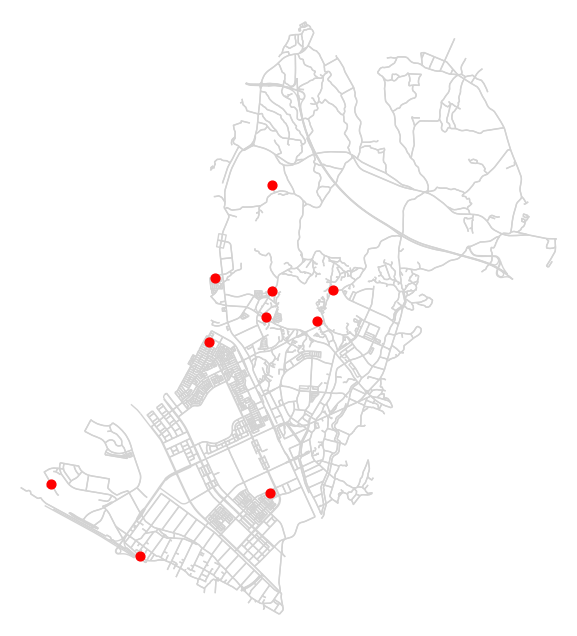

In [27]:
fig, ax = ox.plot_graph(
    G,
    show=False,
    close=False,
    node_size=0,
    bgcolor="white",
    edge_color="lightgray"
)

points_df.plot(
    ax=ax,
    x="x",
    y="y",
    kind="scatter",
    s=40,
    color="red",
    zorder=3
)

- 실제 도로망에서 모든 노드에 대하여, 직접 TSP를 계산하는 것은 비효율적임.

- 따라서 필수 방문 노드를 지정해서 노드간 최단거리를 구한뒤, 이를 바탕으로 TSP를 해결

- 즉, 실제 네트워크 위에 상위 위계의 네트워크를 설정

#### 1.2 노드간 OD 네트워크 생성

In [28]:
def compute_od_matrix(G, node_ids, weight="length"):
    """
    Compute OD shortest path distance matrix among node_ids on graph G.

    Parameters
    ----------
    G : networkx.MultiDiGraph / MultiGraph
        OSMnx graph.
    node_ids : list
        List of node IDs in the graph.
    weight : str
        Edge attribute used as weight (default 'length').

    Returns
    -------
    od_df : pd.DataFrame
        OD matrix with rows/cols labeled by node_id.
        Value is shortest-path distance (same unit as `weight`, usually meters).
        Unreachable pairs are np.inf.
    """
    node_ids = list(node_ids)
    n = len(node_ids)

    # Pre-allocate
    od = np.full((n, n), np.inf, dtype=float)
    np.fill_diagonal(od, 0.0)

    # Compute shortest paths from each origin to all nodes (single-source Dijkstra)
    # This is efficient enough for N=10.
    for i, src in enumerate(node_ids):
        dist_dict = nx.single_source_dijkstra_path_length(G, src, weight=weight)
        for j, dst in enumerate(node_ids):
            if dst in dist_dict:
                od[i, j] = float(dist_dict[dst])

    od_df = pd.DataFrame(od, index=node_ids, columns=node_ids)
    return od_df


In [29]:
# ---- Run (using your sampled nodes) ----
node_ids = points_df["node_id"].tolist()
od_df = compute_od_matrix(G, node_ids, weight="length")

# Optional: also keep a pt_id-labeled matrix for convenience
pt_labels = points_df["pt_id"].astype(str).tolist()
od_pt_df = pd.DataFrame(od_df.values, index=pt_labels, columns=pt_labels)

display(od_df)
# display(od_pt_df)

,2090304549,11370689797,3966737265,10182037328,2925528380,5920272168,9078652289,9170269022,4675574557,12944434516
2090304549,0.000000,2407.495638,7747.319584,3443.547433,1978.780667,4745.313870,823.622177,3408.254836,3530.436215,9302.943328
11370689797,2407.495638,0.000000,7132.714143,2921.732250,734.100254,4799.215753,1774.215480,2668.004788,1532.123558,8688.337886
3966737265,7514.326490,7120.287336,0.000000,9898.796228,6746.719768,3431.227313,6775.225210,5529.287670,7403.027423,3474.528433
10182037328,3443.547433,2921.732250,9911.223035,0.000000,3655.832504,7598.006413,4135.411689,5446.513680,2815.854251,11466.846779
2925528380,1978.780667,694.193883,6791.976895,3615.926133,0.000000,4364.238803,1239.679386,2329.644716,1574.343532,8347.600638
5920272168,4745.313870,4803.007315,3431.227313,7596.307923,4364.238803,0.000000,4076.409811,3419.615780,5100.539119,5966.082414
9078652289,823.622177,1774.215480,7008.218304,4135.411689,1239.679386,4076.409811,0.000000,2669.153555,2791.334934,8563.842047
9170269022,3408.254836,2668.004788,5663.429055,5446.513680,2308.063640,3411.339906,2669.153555,0.000000,2950.744876,7219.052799
4675574557,3530.436215,1532.123558,7415.454231,2815.854251,1614.249903,5102.237609,2791.334934,2950.744876,0.000000,8971.077974
12944434516,9196.068602,8802.029448,3474.528433,11580.538340,8428.461879,5966.082414,8456.967321,7211.029782,9084.769535,0.000000


In [30]:
# ---- Quick diagnostics ----
# 1) Check asymmetry (drive networks can be asymmetric)
asym_max = np.nanmax(np.abs(od_df.values - od_df.values.T))
print("Max |OD - OD^T|:", asym_max)

# 2) Check unreachable pairs
n_inf = np.isinf(od_df.values).sum()
print("Number of unreachable OD pairs (inf):", int(n_inf))

Max |OD - OD^T|: 232.9930941142111
Number of unreachable OD pairs (inf): 0


#### 1.3 Nearest Neighbor로 접근하는 TSP

In [31]:
def tsp_nearest_neighbor(od_df: pd.DataFrame, start=0):
    """
    Solve a TSP tour using Nearest Neighbor heuristic on an OD matrix.

    Parameters
    ----------
    od_df : pd.DataFrame
        Square OD cost matrix. Index/columns must match (same labels).
        Values should be finite; np.inf is allowed for unreachable pairs.
    start : int | str
        Starting node label (must exist in od_df.index).

    Returns
    -------
    tour : list
        Node labels in visit order, including return to start at the end.
        e.g., [start, ..., start]
    total_cost : float
        Sum of OD costs along the tour.
    """
    if not isinstance(od_df, pd.DataFrame):
        raise TypeError("od_df must be a pandas DataFrame")
    if list(od_df.index) != list(od_df.columns):
        raise ValueError("od_df index/columns must be identical and in the same order")

    nodes = list(od_df.index)
    if start not in nodes:
        raise ValueError(f"start={start} not found in od_df index")

    unvisited = set(nodes)
    unvisited.remove(start)

    tour = [start]
    current = start
    total_cost = 0.0

    while unvisited:
        # Choose the nearest unvisited node from current
        row = od_df.loc[current, list(unvisited)]

        # If there are unreachable nodes from current, they will be inf.
        next_node = row.idxmin()
        best_cost = float(row.loc[next_node])

        if not np.isfinite(best_cost):
            raise RuntimeError(
                f"Unreachable step: from {current} to any of {sorted(unvisited)} "
                f"(all costs are inf). Graph may be disconnected or OD matrix incomplete."
            )

        tour.append(next_node)
        total_cost += best_cost
        unvisited.remove(next_node)
        current = next_node

    # Return to start
    back_cost = float(od_df.loc[current, start])
    if not np.isfinite(back_cost):
        raise RuntimeError(f"Cannot return to start: {current} -> {start} is inf/unreachable.")
    tour.append(start)
    total_cost += back_cost

    return tour, total_cost


In [32]:
start_node = od_df.index[0]
tour, cost = tsp_nearest_neighbor(od_df, start=start_node)
print("Tour:", tour)
print("Total cost:", cost)

Tour: [np.int64(2090304549), np.int64(9078652289), np.int64(2925528380), np.int64(11370689797), np.int64(4675574557), np.int64(10182037328), np.int64(9170269022), np.int64(5920272168), np.int64(3966737265), np.int64(12944434516), np.int64(2090304549)]
Total cost: 32065.151188711818


##### 1.3.1 시각화

In [33]:
tour_nodes = [int(x) for x in tour]  # np.int64 -> int 캐스팅(안전)

route_nodes = []
for i in range(len(tour_nodes) - 1):
    src_node = tour_nodes[i]
    dst_node = tour_nodes[i + 1]

    path = nx.shortest_path(G, src_node, dst_node, weight="length")

    if i == 0:
        route_nodes.extend(path)
    else:
        route_nodes.extend(path[1:])

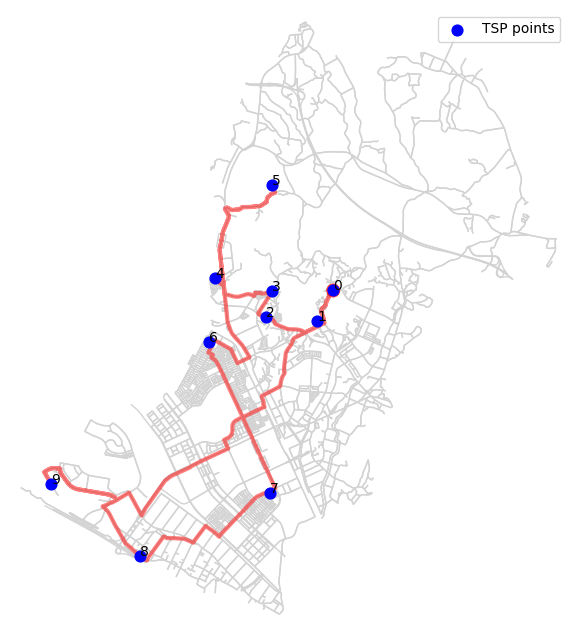

In [34]:

fig, ax = ox.plot_graph_route(
    G,
    route_nodes,
    route_color="red",
    route_linewidth=3,
    node_size=0,
    edge_color="lightgray",
    bgcolor="white",
    show=False,
    close=False
)

# 샘플 포인트 좌표
xs = points_df["x"].values
ys = points_df["y"].values

ax.scatter(
    xs,
    ys,
    c="blue",
    s=60,
    zorder=5,
    label="TSP points"
)

# 라벨 표시 (선택)
for order, nid in enumerate(tour[:-1]):
    nd = G.nodes[int(nid)]
    ax.text(nd["x"], nd["y"], str(order), fontsize=10, zorder=6)

ax.legend()

- Nearest neighbor는 greedy한 탐색을 추구함. 즉, 매 단계에서 제일 가까운 곳만을 확인함.

=> 나중에 돌아오는 비용을 계산하지 않음

- NN은 0->1->2 의 순서만 계산함. 1->2까지 어떻게 가느냐는 최단경로(Dijkstra)문제

#### 1.4 2-opt로 접근하는 TSP

In [35]:
def tour_cost(tour, od_df: pd.DataFrame) -> float:
    """tour: list of labels (must be in od_df.index). closed tour recommended."""
    c = 0.0
    for a, b in zip(tour[:-1], tour[1:]):
        w = float(od_df.loc[a, b])
        if not np.isfinite(w):
            return float("inf")
        c += w
    return c

def two_opt(tour, od_df: pd.DataFrame, max_iters: int = 1000):
    """
    2-opt improvement for a (closed) TSP tour.
    - tour: list like [s, ..., s]
    - od_df: OD matrix (DataFrame) with matching labels
    Returns: (best_tour, best_cost)
    """
    if tour[0] != tour[-1]:
        tour = tour + [tour[0]]

    best = list(tour)
    best_cost = tour_cost(best, od_df)

    n = len(best) - 1  # exclude last duplicate start

    improved = True
    it = 0
    while improved and it < max_iters:
        improved = False
        it += 1

        # i and k are cut points; we reverse segment [i:k]
        for i in range(1, n - 1):
            for k in range(i + 1, n):
                a, b = best[i - 1], best[i]
                c, d = best[k], best[(k + 1) % n]  # next after k (wrap to start)

                # current edges: a->b and c->d
                # new edges: a->c and b->d
                old = float(od_df.loc[a, b]) + float(od_df.loc[c, d])
                new = float(od_df.loc[a, c]) + float(od_df.loc[b, d])

                # skip if unreachable
                if not np.isfinite(old) or not np.isfinite(new):
                    continue

                if new + 1e-12 < old:
                    # apply 2-opt reversal
                    best[i:k+1] = reversed(best[i:k+1])
                    best_cost = best_cost - old + new
                    improved = True
                    break
            if improved:
                break

    return best, best_cost

In [36]:
tour_2opt, cost_2opt = two_opt(tour, od_df)
print("Before:", tour_cost(tour, od_df))
print("After :", cost_2opt)

Before: 32065.151188711818
After : 29823.905482577768


In [37]:
def plot_tour_osm(G, points_df, tour, weight="length",
                 route_color="red", route_linewidth=3):
    """
    Plot a tour (pt_id or node_id) on an OSMnx graph with visit-order labels.
    points_df must have: pt_id, node_id
    """
    pt_set = set(points_df["pt_id"].astype(int).tolist())
    pt_to_node = dict(zip(points_df["pt_id"].astype(int), points_df["node_id"].astype(int)))
    node_to_pt = dict(zip(points_df["node_id"].astype(int), points_df["pt_id"].astype(int)))

    tour_list = [int(x) for x in tour]

    # convert to node_id tour
    if all(t in pt_set for t in tour_list):
        tour_node_ids = [pt_to_node[t] for t in tour_list]
    else:
        tour_node_ids = tour_list

    # ensure closed
    if tour_node_ids[0] != tour_node_ids[-1]:
        tour_node_ids = tour_node_ids + [tour_node_ids[0]]

    # expand into full road route
    route_nodes = []
    for i in range(len(tour_node_ids) - 1):
        src = tour_node_ids[i]
        dst = tour_node_ids[i + 1]
        path = nx.shortest_path(G, src, dst, weight=weight)
        route_nodes.extend(path if i == 0 else path[1:])

    # plot route
    fig, ax = ox.plot_graph_route(
        G, route_nodes,
        route_color=route_color,
        route_linewidth=route_linewidth,
        node_size=0,
        edge_color="lightgray",
        bgcolor="white",
        show=False,
        close=False
    )

    # plot points (sample nodes)
    xs, ys = [], []
    for nid in points_df["node_id"].astype(int).tolist():
        nd = G.nodes[nid]
        xs.append(nd["x"]); ys.append(nd["y"])
    ax.scatter(xs, ys, s=60, zorder=5, label="TSP points")

    # visit-order labels on the actual visited nodes
    visit_order = {nid: i for i, nid in enumerate(tour_node_ids[:-1])}
    for nid, order in visit_order.items():
        nd = G.nodes[int(nid)]
        ax.text(nd["x"], nd["y"], str(order), fontsize=10, color="black", zorder=6)

    ax.legend()
    return fig, ax

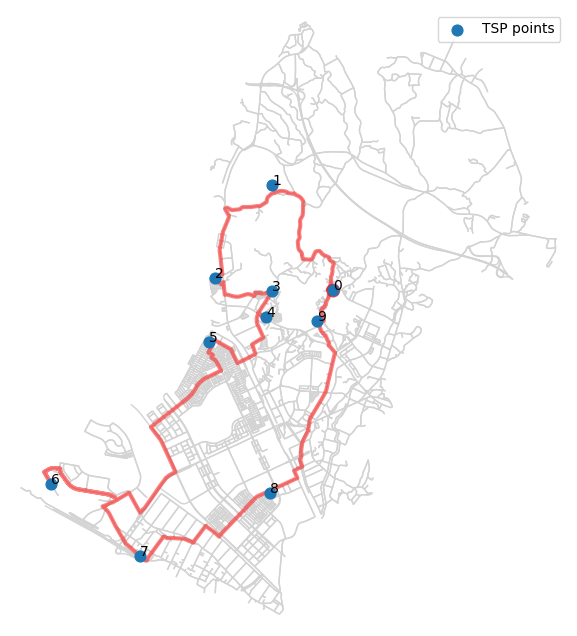

In [38]:
fig2, ax2 = plot_tour_osm(G, points_df, tour_2opt, weight="length")

- NN TSP보다 체감되는 개선폭이 큼. 돌아오는 경로를 고려하면서 겹치는 경로를 최소화 하는 2-opt 방식이기 때문(교차/지그재그 등의 경로를 개선)

- 그러나, 이러한 방법이 항상 최적의 해가 되는 것은 아님. 경로 설정은 지나야 하는 필수 노드와 전체 도로망 노드가 넓어짐에 따라 연산량이 매우 증가하고 복잡해짐.

- 특히, 실제 적용에 있어서는 이용자의 납득가능성, 연산속도, 결과 안전성 등을 고려해야함.

- NN + 2-opt 와 같은 방법은 결국 최적 경로 발견의 초기해로서 사용될 수 있음.

### 2. TSP 적용 관광루트

- 관광지 목록이 주어졌을때, 이 관광지들을 겹치지 않고 지나는 루트

#### 2.1 포천시 관광루트



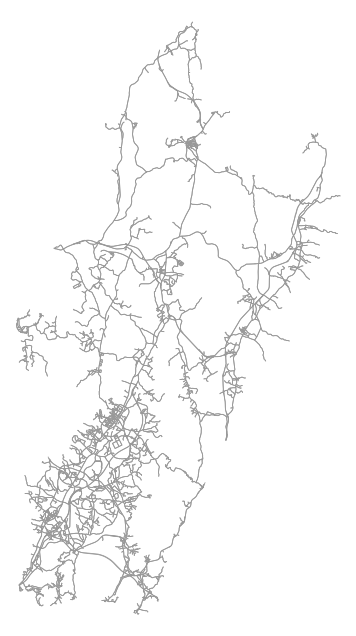

노드 수: 3844
엣지 수: 9128


In [39]:
# 기본 설정
ox.settings.use_cache = True
ox.settings.log_console = True

# 도시 이름
place_name = "Pocheon-si, South Korea"

# 도로 네트워크 (network_type에 따라 보행, 차량용 으로 구분가능)
G = ox.graph_from_place(place_name, network_type="drive")

# 시각화
fig, ax = ox.plot_graph(
    G,
    node_size=0,
    edge_linewidth=0.6,
    bgcolor="white"
)

print(f"노드 수: {len(G.nodes)}")
print(f"엣지 수: {len(G.edges)}")

In [40]:
## 골프장은 빼고 생각하자
pocheon_poi = pd.read_csv('./data/포천시네비게이션검색순위_202510_processed.csv', encoding='cp949')
pocheon_poi = pocheon_poi[pocheon_poi['중분류 카테고리'] != '레저스포츠']
pocheon_poi

,Unnamed: 0,순위,광역시/도,시/군/구,관광지명,중분류 카테고리,소분류 카테고리,검색건수,지번주소,lat,lon,Unnamed: 11
0,0,1,경기도,포천시,산정호수,자연관광,자연경관(하천/해양),23711,경기 포천시 영북면 산정리,38.085676,127.354884,NaN
1,1,2,경기도,포천시,한탄강Y자출렁다리,기타관광,기타관광,22999,경기 포천시 영북면 대화산리 256,38.064173,127.228614,NaN
2,2,3,경기도,포천시,국립수목원,문화관광,테마공원,16762,경기 포천시 소흘읍 직동리 54-2,37.759832,127.169027,NaN
3,3,4,경기도,포천시,포천한탄강가든페스타,문화관광,기타문화관광지,15082,경기 포천시 관인면 중리 526-1,38.084519,127.207789,NaN
4,4,5,경기도,포천시,포천아트밸리,문화관광,공연시설,14788,경기 포천시 신북면 기지리 282,37.923584,127.236688,NaN
5,5,6,경기도,포천시,허브아일랜드,체험관광,농/산/어촌체험,13293,경기 포천시 신북면 삼정리 517 2,37.965979,127.130917,NaN
10,10,11,경기도,포천시,비둘기낭폭포,자연관광,자연경관(산),10343,경기 포천시 영북면 대화산리 415-2,38.079777,127.216921,NaN
15,15,16,경기도,포천시,한탄강생태경관단지,기타관광,기타관광,9333,경기도 포천시 관인면 중리 540-1,38.083021,127.208584,NaN
17,17,18,경기도,포천시,고모저수지,자연관광,자연경관(하천/해양),6900,경기 포천시 소홀읍 고모리,37.798620,127.169972,NaN


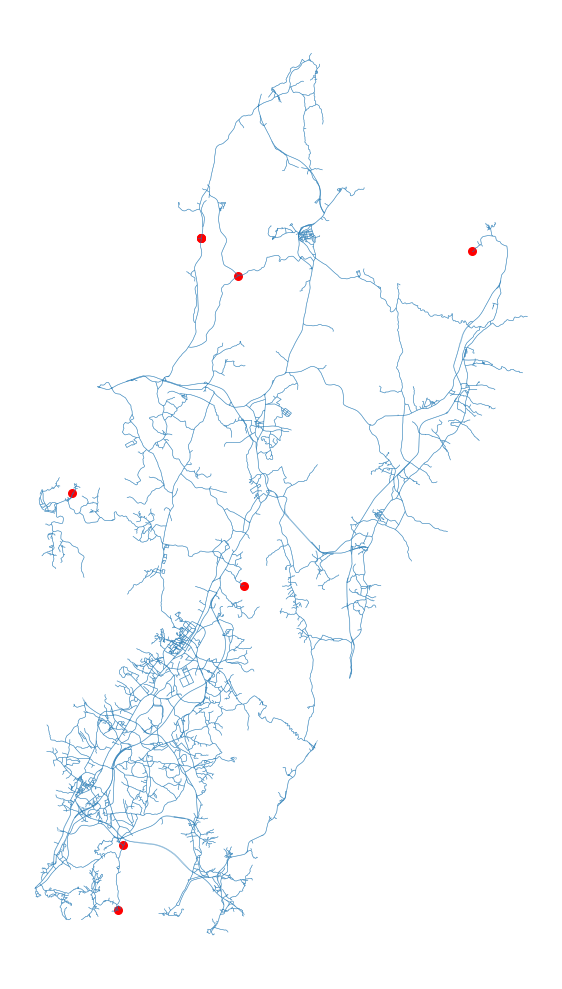

In [41]:
## 관광지별로 가장 가까운 노드를 시각화
# 1) 그래프 → GeoDataFrame
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# 2) 관광지 → GeoDataFrame (WGS84)
spots_gdf = gpd.GeoDataFrame(
    pocheon_poi.copy(),
    geometry=gpd.points_from_xy(pocheon_poi["lon"], pocheon_poi["lat"]),
    crs="EPSG:4326"
)

# 3) 관광지별 가장 가까운 노드(osmid) 구하고, 그 노드만 추출
spots_gdf["nearest_node"] = ox.distance.nearest_nodes(
    G, X=spots_gdf.geometry.x, Y=spots_gdf.geometry.y
)
nearest_nodes_gdf = nodes_gdf.loc[spots_gdf["nearest_node"].values].copy()

# 4) 시각화 (WGS84 그대로 그려도 되지만, 보기 좋게 metric으로 투영 권장)
proj_crs = edges_gdf.estimate_utm_crs()
edges_p = edges_gdf.to_crs(proj_crs)
nodes_p = nodes_gdf.to_crs(proj_crs)
spots_p = spots_gdf.to_crs(proj_crs)
near_p = nearest_nodes_gdf.to_crs(proj_crs)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
edges_p.plot(ax=ax, linewidth=0.4, alpha=0.6)
#spots_p.plot(ax=ax, markersize=30, alpha=0.9)        # 관광지 점
near_p.plot(ax=ax, markersize=30, color = 'red')        # 가장 가까운 노드 (X)

# (선택) 관광지-최근접노드 연결선
# gpd.GeoSeries(
#     [Point(a).buffer(0).centroid for a in []], crs=proj_crs
# )
# for p, n in zip(spots_p.geometry, near_p.geometry):
#     ax.plot([p.x, n.x], [p.y, n.y], linewidth=0.6, alpha=0.7)

ax.set_axis_off()
plt.tight_layout()
plt.show()

이 7곳을 가장 효율적으로 모두 방문하는 방법이 필요함

In [ ]:
nearest_nodes_gdf_plot = nearest_nodes_gdf.loc[~nearest_nodes_gdf.index.duplicated(keep="first"), :] # 중복노드삭제
nearest_nodes_gdf_plot.reset_index(drop=False, inplace=True)
nearest_nodes_gdf_plot.reset_index(drop=False, inplace=True)

nearest_nodes_gdf_plot.rename(columns={'osmid':'node_id', 'index':'pt_id'},inplace=True)

nearest_nodes_gdf_plot

## 가장 아래에서 출발한다고 가정. pt_id 2번이 출발점이 되어야 함
## 출발지 역시 관광지이나, 여기서는 해당 사실을 무시하고 진행

,pt_id,node_id,y,x,junction,street_count,highway,ref,geometry
0,0,10241577732,38.084351,127.370038,NaN,1,NaN,NaN,POINT (127.37004 38.08435)
1,1,5501696585,38.070710,127.229949,NaN,3,NaN,NaN,POINT (127.22995 38.07071)
2,2,9687649138,37.768572,127.165358,NaN,3,NaN,NaN,POINT (127.16536 37.76857)
3,3,10239400803,38.088166,127.207341,NaN,3,NaN,NaN,POINT (127.20734 38.08817)
4,4,7385067091,37.923552,127.237083,NaN,1,NaN,NaN,POINT (127.23708 37.92355)
5,5,4636787492,37.966299,127.132919,NaN,1,NaN,NaN,POINT (127.13292 37.9663)
6,6,9774928976,37.799435,127.167244,NaN,3,NaN,NaN,POINT (127.16724 37.79943)


In [ ]:
### OD 행렬 만들기

node_ids = nearest_nodes_gdf.index.tolist()
od_df = compute_od_matrix(G, node_ids, weight="length")

## 중복된 노드 삭제
od_df = od_df.loc[~od_df.index.duplicated(keep="first"), :]
od_df = od_df.loc[:, ~od_df.columns.duplicated(keep="first")]

# Optional: also keep a pt_id-labeled matrix for convenience
display(od_df)

,10241577732,5501696585,9687649138,10239400803,7385067091,4636787492,9774928976
10241577732,0.000000,25098.356572,53790.252061,33114.987201,34283.860607,42745.982050,50149.272192
5501696585,25106.592740,0.000000,39685.681672,8054.605098,21978.091028,24080.631262,36044.701802
9687649138,53753.207252,39700.380567,0.000000,40476.416758,22568.790884,30524.233229,3640.979869
10239400803,33161.197838,8054.605098,40461.717862,0.000000,22754.127219,24856.667453,36820.737993
7385067091,34208.240348,21982.883073,22549.481051,22758.919264,0.000000,14131.543790,18908.501182
4636787492,42734.639569,24078.129003,30507.032073,24854.165193,14124.249485,0.000000,26866.052204
9774928976,50112.227383,36059.400698,3640.979869,36835.436888,18927.811014,26883.253359,0.000000


In [80]:
start_node = od_df.index[2]
tour, cost = tsp_nearest_neighbor(od_df, start=start_node)
print("Tour:", tour)
print("Total cost:", cost)

Tour: [np.int64(9687649138), np.int64(9774928976), np.int64(7385067091), np.int64(4636787492), np.int64(5501696585), np.int64(10239400803), np.int64(10241577732), np.int64(9687649138)]
Total cost: 155784.51867251509


In [81]:
## NN 이후 2-opt를 적용해 개선
tour_2opt, cost_2opt = two_opt(tour, od_df)
print("Before:", tour_cost(tour, od_df))
print("After :", cost_2opt)

Before: 155784.51867251509
After : 145380.23222298286


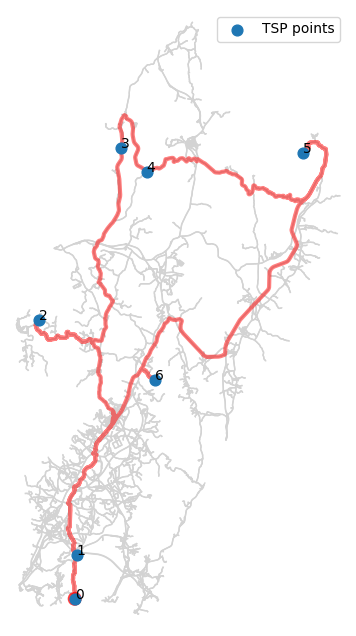

In [82]:
fig2, ax2 = plot_tour_osm(G, nearest_nodes_gdf_plot, tour_2opt, weight="length")

- 최소비용의 관광루트를 만들어 냈으나, 각 관광지가 중심 도로에서 많이 떨어져 있기에 직접 임의로 설정하는 것과 크게 다르지 않음